In [58]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read ERA as GRIB files

The [ERA5-Land monthly averaged Reanalysis-data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=overview) has been manually downloaded from the copernicus climate change service.

In [59]:
# tmean and LAI 1968-2023
df1 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgid'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 1968 - 2001
df2 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgas'}).to_dataframe().reset_index().dropna().reset_index(drop=True)
# rain 2002-2023
df3 = xr.open_dataset("files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib", filter_by_keys={'stepType': 'avgad'}).to_dataframe().reset_index().dropna().reset_index(drop=True)

rain = pd.concat([df2, df3], ignore_index=True).dropna().reset_index(drop=True)
era = df1.merge(rain, on=["time", "latitude", "longitude", "number", "step", "surface", "valid_time"])

Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file
Ignoring index file 'files/ERA/raw/adaptor.mars.internal-1689317281.2867105-29547-5-0a3f055d-5520-4dc7-b544-9d9307e82d48.grib.923a8.idx' incompatible with GRIB file


### 2. Preprocess ERA

In [60]:
# Kelvin to Celsius
era["t2m"] = era["t2m"].apply(lambda x: x - 273.15)
# Precipitation from m to mm
era["tp"] = era["tp"].apply(lambda x: x * 1000)
# time to datetime
era["time"] = pd.to_datetime(era["time"])
era["valid_time"] = pd.to_datetime(era["valid_time"])

era = (era
       .sort_values(by=["time", "latitude", "longitude"])
       .loc[:, ["time", "latitude", "longitude", "t2m", "tp"]]
       .rename(columns={"latitude":"lat", "longitude":"lon", "t2m":"tmean", "tp":"rain"})
       .reset_index(drop=True))

era["lat"] = era["lat"].round(1)
era["lon"] = era["lon"].round(1)
era["month"] = era["time"].dt.month
era["year"] = era["time"].dt.year
era = era.loc[era["month"].between(9,11) & (era["year"].between(1993,2016))].reset_index(drop=True)
era = era[["time", "lat", "lon", "rain", "tmean", "month", "year"]]
era = gpd.GeoDataFrame(era, geometry=gpd.points_from_xy(era["lon"], era["lat"], crs="EPSG:4326"))

era.head(2)

,time,lat,lon,rain,tmean,month,year,geometry
0,1993-09-01,-42.0,-69.0,0.549607,3.03335,9,1993,POINT (-69.00000 -42.00000)
1,1993-09-01,-42.0,-68.9,0.521474,2.65835,9,1993,POINT (-68.90000 -42.00000)


### 3. Filter ERA and upscale grid cells

In [86]:
study_region = gpd.read_file("files/shapefiles/study_region.shp")

era["lat_bin"] = pd.cut(era["lat"], np.arange(-41.5, -26.5, 1), labels=np.arange(-41, -27, 1))
era["lon_bin"] = pd.cut(era["lon"], np.arange(-65.5, -55.5, 1), labels=np.arange(-65, -56, 1))

era_filtered = era.dropna().groupby(["lat_bin", "lon_bin", "year", "month"])[["rain", "tmean"]].mean().reset_index()
era_filtered = era_filtered.rename(columns={"lat_bin":"lat", "lon_bin":"lon"})
era_filtered = gpd.GeoDataFrame(era_filtered, geometry=gpd.points_from_xy(era_filtered["lon"], era_filtered["lat"], crs="EPSG:4326"))

coordinates = gpd.sjoin(era[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
era = era.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

coordinates = gpd.sjoin(era_filtered[["geometry", "lat", "lon"]].drop_duplicates(), study_region).reset_index(drop=True)[["name", "lat", "lon"]]
era_filtered = era_filtered.merge(coordinates[["lat", "lon"]], on=["lat", "lon"], how="right")

era_filtered.head()

,lat,lon,year,month,rain,tmean,geometry
0,-40,-63,1993,9,0.670627,11.306104,POINT (-63.00000 -40.00000)
1,-40,-63,1993,10,1.130262,15.560000,POINT (-63.00000 -40.00000)
2,-40,-63,1993,11,1.814281,17.768086,POINT (-63.00000 -40.00000)
3,-40,-63,1994,9,0.847382,12.451104,POINT (-63.00000 -40.00000)
4,-40,-63,1994,10,1.015687,14.237861,POINT (-63.00000 -40.00000)


### ATTEMPTS

<Axes: xlabel='tmean', ylabel='rain'>

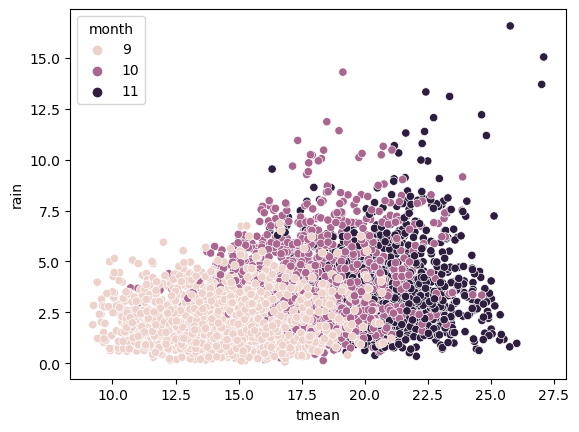

In [127]:
sns.scatterplot(era_filtered, x="tmean", y="rain", hue="month")

<Axes: xlabel='tmean', ylabel='rain'>

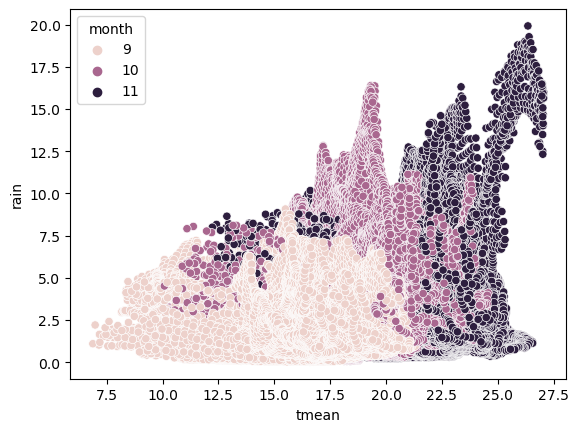

In [121]:
sns.scatterplot(era, x="tmean", y="rain", hue="month")

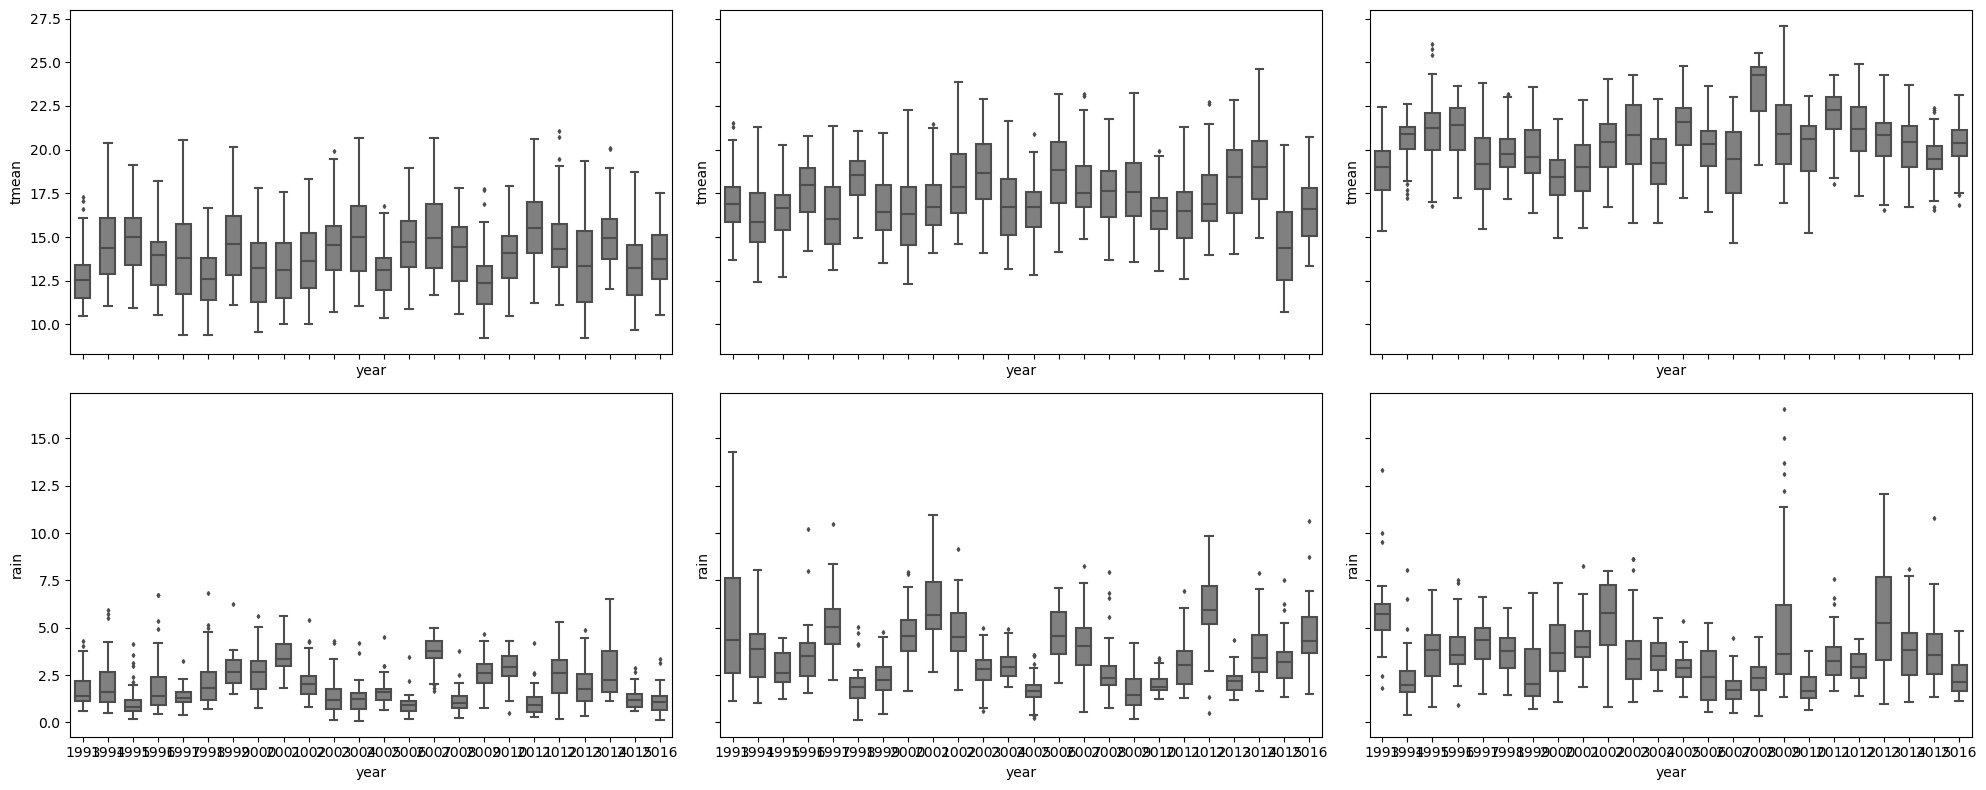

In [116]:
fig, axs = plt.subplots(2, 3, figsize=(20,8), sharex=True, sharey="row")

sns.boxplot(data=era_filtered.loc[(era_filtered["month"] == 9), ["year", "tmean"]], x="year", y="tmean", width=.6, fliersize=2, ax=axs[0][0], color="grey")
sns.boxplot(data=era_filtered.loc[(era_filtered["month"] == 10), ["year", "tmean"]], x="year", y="tmean", width=.6, fliersize=2,ax=axs[0][1], color="grey")
sns.boxplot(data=era_filtered.loc[(era_filtered["month"] == 11), ["year", "tmean"]], x="year", y="tmean", width=.6, fliersize=2,ax=axs[0][2], color="grey")

sns.boxplot(data=era_filtered.loc[(era_filtered["month"] == 9), ["year", "rain"]], x="year", y="rain", width=.6, fliersize=2,ax=axs[1][0], color="grey")
sns.boxplot(data=era_filtered.loc[(era_filtered["month"] == 10), ["year", "rain"]], x="year", y="rain", width=.6, fliersize=2,ax=axs[1][1], color="grey")
sns.boxplot(data=era_filtered.loc[(era_filtered["month"] == 11), ["year", "rain"]], x="year", y="rain", width=.6, fliersize=2, ax=axs[1][2], color="grey")

plt.tight_layout()

### 4. Visualize

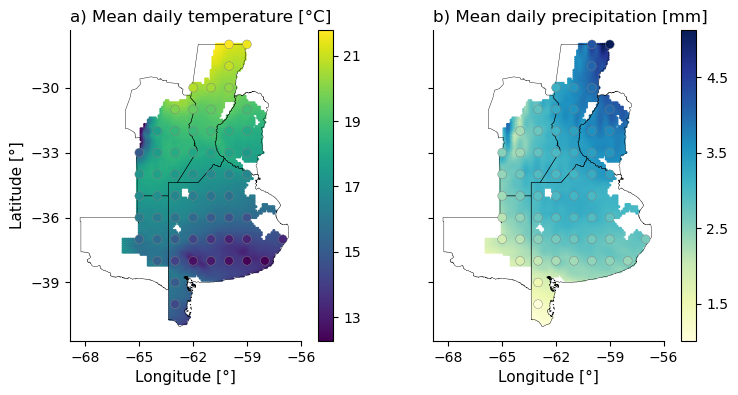

In [57]:
gdf_adm1 = gpd.read_file("files/shapefiles/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")
gdf_adm1 = gdf_adm1.loc[gdf_adm1["ADM1_ES"].isin(['Buenos Aires', 'Entre Ríos', 'La Pampa', 'Córdoba', 'Santa Fe'])].reset_index(drop=True)

era_plot = era.dissolve(
                by=["lat", "lon"],
                aggfunc={
                    "rain": "mean",
                    "tmean": "mean",
                }
            ).reset_index()

era_plot_grid = era_filtered.dissolve(
                        by=["lat", "lon"],
                        aggfunc={
                            "rain": "mean",
                            "tmean": "mean",
                        }
                    ).reset_index()

era_plot.to_file('files/shapefiles/era_plot_high_resolution.shp', driver='ESRI Shapefile')
era_plot_grid.dropna()[["geometry", "tmean", "rain"]].reset_index(drop=True).to_file('files/shapefiles/era_plot_grid.shp', driver='ESRI Shapefile')

fig, axs = plt.subplots(1, 2, figsize=(8,4), sharey=True)
axs = axs.ravel()


era_plot.plot(column="tmean", ax=axs[0], markersize=1.5, legend=True, legend_kwds={'ticks': list(range(13,22,2))})
gdf_adm1.plot(ax=axs[0], color="none", edgecolor="black", linewidth=.3)
era_plot_grid.plot(column="tmean", ax=axs[0], markersize=40, edgecolor="grey", linewidth=.3, legend=False)
axs[0].set_title("a) Mean daily temperature [°C]", loc="left");
axs[0].set_ylabel("Latitude [°]", size=11);
axs[0].set_xlabel("Longitude [°]", size=11);
axs[0].set_yticks(list(range(-42, -24, 3)))
axs[0].set_xticks([-68, -65, -62, -59, -56])
axs[0].spines[['right', 'top']].set_visible(False)


era_plot.plot(column="rain", ax=axs[1], legend=True, markersize=1.5, cmap="YlGnBu", legend_kwds={'ticks': list(np.arange(1.5,5.5,1))})
gdf_adm1.plot(ax=axs[1], color="none", edgecolor="black", linewidth=.3)
era_plot_grid.plot(column="rain", ax=axs[1], markersize=40, edgecolor="grey", linewidth=.3, cmap="YlGnBu", legend=False)
axs[1].set_title("b) Mean daily precipitation [mm]", loc="left");
#axs[1].set_ylabel("Latitude [°]", size=11);
axs[1].set_xlabel("Longitude [°]", size=11);
#axs[1].set_yticks(list(range(-42, -24, 3)))
axs[1].set_xticks([-68, -65, -62, -59, -56])
axs[1].spines[['right', 'top']].set_visible(False)

plt.tight_layout()

plt.savefig("files/figures/figure2.svg")
plt.show()

### 5. Restructure dataset

In [6]:
era_features = era_filtered.pivot(index="year", columns=["lat", "lon", "month"], values=["rain", "tmean"])
era_features.columns = ["{}_{}_{}_{}".format(s[0],s[1],s[2],s[3]) for s in era_features.columns]
era_features = era_features.reset_index()
era_features.head()

,year,rain_-40_-63_9,rain_-40_-63_10,rain_-40_-63_11,rain_-39_-63_9,rain_-39_-63_10,rain_-39_-63_11,rain_-38_-64_9,rain_-38_-64_10,rain_-38_-64_11,...,tmean_-30_-60_11,tmean_-29_-60_9,tmean_-29_-60_10,tmean_-29_-60_11,tmean_-28_-60_9,tmean_-28_-60_10,tmean_-28_-60_11,tmean_-28_-59_9,tmean_-28_-59_10,tmean_-28_-59_11
0,1993,0.670627,1.130262,1.814281,0.716089,2.022627,2.440457,0.881539,2.074539,3.497822,...,21.296621,16.584326,20.568613,21.658359,17.307646,21.267793,22.227148,17.075576,21.498145,22.421328
1,1994,0.847382,1.015687,0.386217,1.142002,1.290384,1.001724,1.012144,1.776602,1.572551,...,21.830527,19.365068,20.438232,22.027578,20.371104,21.251240,22.437793,20.089111,21.267920,22.614141
2,1995,0.159483,1.355044,1.183462,0.216376,1.739493,2.207788,0.158238,1.475547,2.923975,...,24.081221,18.384072,19.746191,25.411514,19.093174,20.283477,26.025752,18.963564,20.000977,25.744502
3,1996,0.431490,2.184107,0.927823,0.796497,2.241182,1.936562,0.932992,2.019784,2.035488,...,23.235049,17.549082,20.636279,23.252744,18.176309,20.804053,23.367686,17.754316,20.653174,23.578154
4,1997,1.579427,2.228900,1.992567,1.579584,2.381040,1.929469,1.900411,2.539490,1.686103,...,22.754453,19.165195,20.688779,23.076641,20.575977,21.351982,23.679609,20.097109,21.077139,23.816895


In [7]:
era_features.to_csv("files/ERA/processed/era_tmean_rain_all_departments.csv", index=False)

### 6. Basis Expansion

In [8]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for year in list(range(1993, 2017)):
        # split
        features_used_for_standardization = data.loc[data["year"] != year, [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        features_to_standardize = data.loc[(data["year"] == year), [c for c in data.columns if c != "year"]].reset_index(drop=True).copy()
        # standardize
        features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
        # bring it together
        year = data.loc[(data["year"] == year), ["year"]].reset_index(drop=True)
        standardized_df = pd.concat([year, features_standardized], axis=1)
        standardized_data.append(standardized_df)
    df_standardized = pd.concat(standardized_data, ignore_index=True)
    return df_standardized

def apply_basis_expansion(data):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    
    # store features and target in variables for better readability
    X_temp = df_standardized.loc[:, [c for c in df_standardized.columns if ("tmean" in c)]]
    X_rain = df_standardized.loc[:, [c for c in df_standardized.columns if ("rain" in c)]]
    y = df_standardized.loc[:, ["year"]].reset_index(drop=True)
    
    # basis expansion to linear model
    X_tmean_squared = X_temp.mul(X_temp)
    X_rain_squared = X_rain.mul(X_rain)
    X_rain_tmean = X_rain * X_temp.values
    X_tmean_squared.columns = ["tmeansquared_{}".format("_".join(c.split("_")[1:])) for c in X_tmean_squared.columns]
    X_rain_squared.columns = ["rainsquared_{}".format("_".join(c.split("_")[1:])) for c in X_rain_squared.columns]
    X_rain_tmean.columns = ["tmeanrain_{}".format("_".join(c.split("_")[1:])) for c in X_rain_tmean.columns]
    
    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_rain_tmean, left_index=True, right_index=True), left_index=True, right_index=True))
    data_expanded = pd.concat([y, X], axis=1)

    # standardize expanded features again
    df_standardized = standardize_loyo(data_expanded)
    
    return df_standardized

In [9]:
era_basis_expansion = apply_basis_expansion(era_features)
era_basis_expansion.head(2)

,year,tmeansquared_-40_-63_9,tmeansquared_-40_-63_10,tmeansquared_-40_-63_11,tmeansquared_-39_-63_9,tmeansquared_-39_-63_10,tmeansquared_-39_-63_11,tmeansquared_-38_-64_9,tmeansquared_-38_-64_10,tmeansquared_-38_-64_11,...,tmeanrain_-30_-60_11,tmeanrain_-29_-60_9,tmeanrain_-29_-60_10,tmeanrain_-29_-60_11,tmeanrain_-28_-60_9,tmeanrain_-28_-60_10,tmeanrain_-28_-60_11,tmeanrain_-28_-59_9,tmeanrain_-28_-59_10,tmeanrain_-28_-59_11
0,1993,-0.804068,-0.551056,-0.170074,-0.954209,-0.487716,0.273058,-0.939407,-0.438069,0.613410,...,-0.536544,-0.909878,-0.670691,-0.412663,0.28843,-0.357500,-0.707764,-0.046632,-0.133073,-1.036243
1,1994,-0.499194,-0.232915,0.068395,-0.662785,-0.244537,0.180761,-0.757140,-0.254513,0.150463,...,0.132331,0.673351,-0.155326,-0.140211,0.01030,0.212708,-0.246367,0.402256,-0.079192,-0.271787


### 7. EXPORT

In [10]:
era_basis_expansion.to_csv("files/ERA/processed/era_basis_expansion_all_departments.csv", index=False)